# Q1: Baye's Theorem

## Part a) Define the following quantities: P[-|M]; P[+|not M]; P[not M].

P[-|M] = 1 - P[not -|M] = 1 - P[+|M] = 1 - 0.95 = 0.05  
P[+|not M] = 1 - P[not +|not M] = 1 - P[-|not M] = 1 - 0.95 = 0.05  
P[not M] = 1 - P[M] = 1 - 0.01 = 0.99

## Part b) You have had a chemical test and have tested positive; should you be alarmed?

P[M|+] = P[M]*P[+|M]/P[+] = 0.01*0.95/P[+]  
P[+] = P[M]*P[+|M] + P[not M]*P[+|not M] = 0.01*0.95+0.99*0.05 = 0.0095+0.0495 = 0.059  
P[M|+] = 0.01*0.95/0.059 = 0.16  
There is only 16% chance you actually have the marker if you test positive, which wouldn't be very alarming. This seems to be due to the low chance of actually having the marker (1%) which is present in the numerator

## Part c) Suppose that frequency of marker was higher by a factor of 10, i.e. P[M] = 0.10.

P[M|+] = P[M]*P[+|M]/P[+] = 0.1*0.95/P[+]  
P[+] = P[M]*P[+|M] + P[not M]*P[+|not M] = 0.1*0.95+0.90*0.05 = 0.14 
P[M|+] = 0.1*0.95/0.14 = 0.68
There is a 68% chance of having the marker now if someone has tested positive, which would be alarming

#  Q2: Gaussian Naive Bayes

In [1]:
import pandas as pd
import numpy as np
import sklearn.model_selection as skl_model
import matplotlib.pyplot as plt

df=pd.read_csv('~/Downloads/wines.csv')
df

,Alcohol %,Malic Acid,Ash,Alkalinity,Mg,Phenols,Flavanoids,Phenols.1,Proantho-cyanins,Color intensity,Hue,OD280 315,Proline,Start assignment,ranking
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1,1
1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1,1
2,14.83,1.64,2.17,14.0,97,2.80,2.98,0.29,1.98,5.20,1.08,2.85,1045,1,1
3,14.12,1.48,2.32,16.8,95,2.20,2.43,0.26,1.57,5.00,1.17,2.82,1280,1,1
4,13.75,1.73,2.41,16.0,89,2.60,2.76,0.29,1.81,5.60,1.15,2.90,1320,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.40,4.60,2.86,25.0,112,1.98,0.96,0.27,1.11,8.50,0.67,1.92,630,3,3
174,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835,3,3
175,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840,3,3
176,14.13,4.10,2.74,24.5,96,2.05,0.76,0.56,1.35,9.20,0.61,1.60,560,3,3


### the Naive Bayes Classifier

In [2]:
#normalize data
feats=df.drop(['Start assignment','ranking'],axis=1)
avg=np.average(feats,axis=0)
std=np.std(feats,axis=0)
feats=feats-avg
feats=feats/std
classes = df["ranking"]

In [3]:
class NaiveBayesClassifier():
    def __init__(self):
        self.type_indices={}    # store the indices of wines that belong to each cultivar as a boolean array of length 178
        self.type_stats={}      # store the mean and std of each cultivar
        self.ndata = 0
        self.trained=False
    
    @staticmethod
    def gaussian(x,mean,std):
        return 1/(np.sqrt(2*np.pi)*std)*np.exp(-(x-mean)**2/(2*std**2))
    
    @staticmethod
    def calculate_statistics(x_values):
        # Returns a list with length of input features. Each element is a tuple, with the input feature's average and standard deviation
        n_feats=x_values.shape[1]
        return [(np.average(x_values[:,n]),np.std(x_values[:,n])) for n in range(n_feats)]
    
    @staticmethod
    def calculate_prob(x_input,stats): 
        """Calculate the probability that the input features belong to a specific class(P(X|C)), defined by the statistics of features in that class
        x_input: np.array shape(nfeatures)
        stats: list of tuple [(mean1,std1),(means2,std2),...]
        """ 
        init_prob=1
        
        # P(X|C) = P(x1|C)*P(x2|C)*... where each of them is a gaussian
        # iterate over each features 
        for x_value,single_stat in zip(x_input,stats):
            init_prob *= NaiveBayesClassifier.gaussian(x_value,single_stat[0],single_stat[1]) ###later verify correct ordering of mean and std
        return init_prob
    
    def fit(self,xs,ys):
        # Train the classifier by calculating the statistics of different features in each class
        self.ndata = len(ys)
        for y in set(ys):
            type_filter= (ys==y)
            self.type_indices[y]=type_filter
            self.type_stats[y]=NaiveBayesClassifier.calculate_statistics(xs[type_filter])
        self.trained=True
            
    def predict(self,xs):
        # Do the prediction by outputing the class that has highest probability
        if len(xs.shape)>1:
            print("Only accepts one sample at a time!")
        if self.trained:
            guess=None
            max_prob=0
            # P(C|X) = P(X|C)*P(C) / sum_i(P(X|C_i)*P(C_i)) (deniminator for normalization only, can be ignored)
            for y_type in self.type_stats:
                ###DETERMINE WHETHER xs is one sample or several,,,xs should prolly be shape (13,1)
                prob = self.calculate_prob(xs,self.type_stats[y_type])*self.type_indices[y_type].sum()/178 ###make sure that P(C) is correct with accessing type_indices
                if prob>max_prob:
                    max_prob=prob
                    guess=y_type
            return guess
        else:
            print("Please train the classifier first!")

A performance tester:

In [4]:
#turn df to numpy arrays
feats = feats.values
classes = classes.values
classifier = NaiveBayesClassifier()

### Part a) the probability distribution function(PDF) is a gaussian. Why do we choose this functional form?

In [5]:
#calculate alcohol % mean and std for cultivar 1 from normalized data
type_stats = classifier.calculate_statistics(feats[classes==1])
alc_stats = type_stats[0]

#normalize given alochol % of 13 to fit data
alc_norm = (13-avg[0])/std[0]

#calculate prob
prob = classifier.gaussian(alc_norm,alc_stats[0],alc_stats[1])
prob

0.1881115268655778

#### Gaussian PDF works well with continuous data, as is the case for the continuous values of the 13 features in our datasets. We also only need to determine mean and std of features in our data, which is easy to do, to use it. The probability for an alcohol % of 13 is about 19%

## Part b) Take the provided code for NaiveBayesClassifier, use your normalized chemical descriptor data from  HW#2,  and  divide  your  data  into  3-fold  training  and  testing  groups,

In [6]:
kf = skl_model.KFold(n_splits=3,shuffle=True)
for train_index,test_index in kf.split(feats):
    #print('Train: ',train_index, ' Test: ', test_index)
    x_train,x_test = feats[train_index],feats[test_index]
    y_train,y_test = classes[train_index],classes[test_index]
    classifier = NaiveBayesClassifier()
    score = 0
    classifier.fit(x_train,y_train)
    for i in range(len(y_test)):
        if classifier.predict(x_test[i]) == y_test[i]:
            score += 1
    print(score/len(y_test))


0.9666666666666667
0.9830508474576272
0.9322033898305084


### Using 3-fold validation, we reach accuracy score consistently in the range of 95-98%, which is much better than previous methods that yielded accuracy scores far below 80% for the wine dataset

In [7]:
def calculate_accuracy(model,xs,ys):
    y_pred=np.zeros_like(ys)
    for idx,x in enumerate(xs):
        y_pred[idx]=model.predict(x)
    return np.sum(ys==y_pred)/len(ys)

calculate_accuracy(classifier,feats,classes)



0.9662921348314607

# Q3: Softmax and Cross Entropy Loss.

Hint: cross entropy loss of pytorch (https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) works by taking in y_hat(your model prediction) as a tensor of size (Batchsize, number of class) and y(reference values) as a tensor of size(Batchsize,). You can think of each element of the y_hat tensor(X_ij) as the probability that the element i belong to class j. And each element of y should be a int/torch.long that is a number between \[0,number_of_class-1]

### Part a) Pass the data through the network once without backpropagation and print out the output. 

In [8]:
from torch import nn
import torch

In [9]:
#convert numpy data to tensors
feats_tensor = torch.tensor(feats,dtype=torch.float)
classes_tensor = torch.tensor(classes-1,dtype=torch.long)

In [10]:
#construct PyTorch model
class MLP(nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        self.layers = nn.Sequential(
        nn.Linear(13,3),
        nn.Softmax(dim=1) 
        )
        
    def forward(self,x):
        return self.layers(x)

model1 = MLP()
print(model1)


MLP(
  (layers): Sequential(
    (0): Linear(in_features=13, out_features=3, bias=True)
    (1): Softmax(dim=1)
  )
)


In [11]:
#define loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(),lr=1e-3)

def calculate_accuracy_NN(model,xs,ys):
    pred = model(torch.tensor(xs,dtype=torch.float))
    pred= torch.argmax(pred,dim=1)
    pred = pred.detach().numpy()    
    return np.sum(ys==pred+1)/len(ys)

#untrained model prediction and loss
pred = model1(feats_tensor)
loss = loss_func(pred,classes_tensor)
print("Output: ",pred)
print("Loss: ",loss.item())

#accuracy of untrained model
calculate_accuracy_NN(model1,feats,classes)

    


Output:  tensor([[0.3383, 0.4607, 0.2010],
        [0.3362, 0.2814, 0.3824],
        [0.3633, 0.4356, 0.2011],
        [0.3085, 0.4470, 0.2444],
        [0.3020, 0.3572, 0.3408],
        [0.3894, 0.3569, 0.2537],
        [0.3197, 0.4616, 0.2187],
        [0.2432, 0.3217, 0.4350],
        [0.2917, 0.3085, 0.3998],
        [0.2459, 0.4570, 0.2971],
        [0.3022, 0.4505, 0.2473],
        [0.4490, 0.3103, 0.2407],
        [0.3322, 0.2822, 0.3856],
        [0.2771, 0.3189, 0.4039],
        [0.2563, 0.3351, 0.4087],
        [0.2625, 0.4112, 0.3263],
        [0.3599, 0.3788, 0.2614],
        [0.2972, 0.3328, 0.3700],
        [0.3345, 0.3108, 0.3547],
        [0.2904, 0.3289, 0.3806],
        [0.4146, 0.3103, 0.2751],
        [0.2120, 0.2022, 0.5859],
        [0.2800, 0.3486, 0.3714],
        [0.2618, 0.5028, 0.2354],
        [0.2147, 0.4925, 0.2928],
        [0.2769, 0.1972, 0.5259],
        [0.2282, 0.2353, 0.5364],
        [0.2928, 0.3430, 0.3642],
        [0.2482, 0.2480, 0.5038],
     

0.17415730337078653

In [12]:
#train model using loss function and ADAM

for i in range(100):
    pred = model1(feats_tensor)
    loss = loss_func(pred,classes_tensor)
    optimizer.zero_grad
    loss.backward()
    optimizer.step()
    print("Loss: ",loss.item())

#trained model accuracy 
calculate_accuracy_NN(model1,feats,classes)



Loss:  1.163031816482544
Loss:  1.1609236001968384
Loss:  1.1588826179504395
Loss:  1.1568512916564941
Loss:  1.1548089981079102
Loss:  1.152746558189392
Loss:  1.1506588459014893
Loss:  1.1485426425933838
Loss:  1.1463960409164429
Loss:  1.1442179679870605
Loss:  1.1420073509216309
Loss:  1.1397639513015747
Loss:  1.1374870538711548
Loss:  1.1351767778396606
Loss:  1.1328331232070923
Loss:  1.1304558515548706
Loss:  1.1280455589294434
Loss:  1.1256020069122314
Loss:  1.1231260299682617
Loss:  1.1206175088882446
Loss:  1.1180771589279175
Loss:  1.1155052185058594
Loss:  1.1129025220870972
Loss:  1.11026930809021
Loss:  1.107606053352356
Loss:  1.104913592338562
Loss:  1.1021925210952759
Loss:  1.0994434356689453
Loss:  1.096666932106018
Loss:  1.0938639640808105
Loss:  1.0910348892211914
Loss:  1.088180661201477
Loss:  1.0853019952774048
Loss:  1.082399845123291
Loss:  1.079474687576294
Loss:  1.07652747631073
Loss:  1.0735588073730469
Loss:  1.0705698728561401
Loss:  1.067560911178588

0.848314606741573

### The untrained model consistently has a loss of around 1 and the accuracy varies a lot but seems to average around 33% (same as randomly assigning cultivar for each wine). Training the model shows a decrease in the error and the accuracy for the model is much higher, usually ranging fro 82-86%. Without softmax, the model seems to return three numbers usually ranging between -1 and 1 for every sample, which seems hard to compare to the actual cultivar for the wine. With softmax, the model returns again three numbers, but this time they are always positive and add up to 1 (and numbers higher than others before the softmax activation remain higher after the activation function). Each of these three numbers represents the probability that the particular sample belongs to each the three cultivars, and it is thus much easier to compare to the actual values and compute a loss value.

## Part b) Divide  your  data  into  3-fold  training  and  testing  groups,  within  each  fold  further  divide  your training data into 80% training and 20% validation, choose the model for the epoch with lowest validation error.

In [13]:
from sklearn.model_selection import train_test_split

def train_and_val(model,train_X,train_y,epochs,draw_curve=True): ### I think we only need to use this for 3b
    """
    Parameters
    --------------
    model: a PyTorch model
    train_X: np.array shape(ndata,nfeatures)
    train_y: np.array shape(ndata)
    epochs: int
    draw_curve: bool
    """
    ### Define your loss function, optimizer. Convert data to torch tensor ###
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
    train_X = torch.tensor(feats,dtype=torch.float)
    train_y = torch.tensor(classes-1,dtype=torch.long)
    
    
    ### Split training examples further into training and validation ###
    train_X,val_X,train_y,val_y= train_test_split(train_X,train_y,train_size=0.8)
    val_array=[]
    weights = model.state_dict()
    lowest_val_loss = np.inf
    
    for i in range(epochs):
        #Compute the loss and do backpropagation
        pred = model(train_X)
        loss = loss_func(pred,train_y)
        optimizer.zero_grad
        loss.backward()
        optimizer.step()
        #validation
        with torch.no_grad(): #I'm guessing we don't want backprop for validation so that's why here
            #Compute the validation loss
            val_loss = loss_func(model(val_X),val_y)
            
        val_array.append(val_loss.item())
        
        if val_loss < lowest_val_loss:
                lowest_val_loss = val_loss
                weights = model.state_dict()
                
     # The final number of epochs is when the minimum error in validation set occurs    
    final_epochs=np.argmin(val_array)+1
    print("Number of epochs with lowest validation:",final_epochs)
    # Recover the model weight, and train with full training data (including validation data)
    model.load_state_dict(weights)

    if draw_curve:
        plt.figure()
        plt.plot(np.arange(len(val_array))+1,val_array,label='Validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
    return weights



Number of epochs with lowest validation: 100
Number of epochs with lowest validation: 100
Number of epochs with lowest validation: 100
[0.7651075720787048, 0.6672074198722839, 0.6277082562446594]


0.9606741573033708

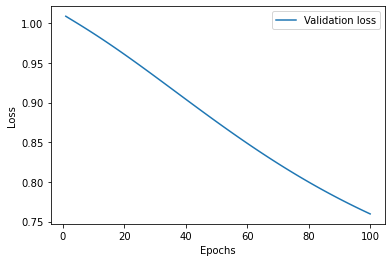

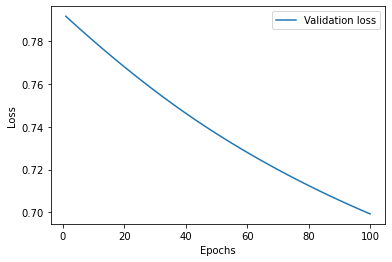

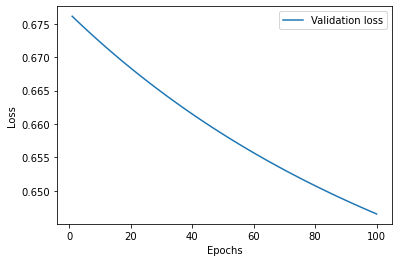

In [14]:
#create new instance of PyTorch model for this question
model2 = MLP()

#3-fold cross validation
kf = skl_model.KFold(n_splits=3,shuffle=True)

test_array=[]
lowest_test_loss = np.inf
best_weights = model2.state_dict()

#store weights of model with lowest test_error
for train_index,test_index in kf.split(feats):
    #print('Train: ',train_index, ' Test: ', test_index)
    x_train,x_test = feats[train_index],feats[test_index]
    y_train,y_test = classes[train_index],classes[test_index]
    x_test = torch.tensor(x_test,dtype=torch.float)
    y_test = torch.tensor(y_test-1,dtype=torch.long)
    temp_weights = train_and_val(model2,x_train,y_train,100)
    model2.load_state_dict(temp_weights)
    with torch.no_grad():
        test_loss = loss_func(model2(x_test),y_test)
    test_array.append(test_loss.item())
    if test_loss < lowest_test_loss:
            lowest_test_loss = test_loss
            best_weights = temp_weights

#test such model
print(test_array)
model2.load_state_dict(best_weights)
calculate_accuracy_NN(model2,feats,classes)

### Three-fold cross validation yielded better results, with the best returned model obtaining average accuracies of 95%